In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg.dsolve import spsolve
from scipy.sparse.linalg import bicgstab, bicg, cg, cgs, gmres, lgmres, minres, qmr, gcrotmk
import matplotlib.animation as animation
from IPython.display import HTML

import time
start_time = time.time()
%matplotlib inline

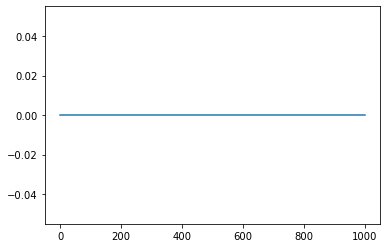

In [2]:
Nx = 1000
Lx = 1000
dx = Lx/(Nx-1)
cfl = 0.3
T = 100
Nprint = 100
dt_print = T/Nprint
mu_lim = 0.4
lbda = 1
Temp = 3
sqrtTemp = np.sqrt(Temp)
B = 1
F0 = 1
f0 = 1

def f(c):
    return c
R = Lx/40

X = np.linspace(0,Lx,Nx)
mu0 = np.zeros(Nx)
mu0[np.abs(X-Lx/2)<R]=0.01
u0 = np.zeros(Nx)
#v0 = np.zeros(Nx)
rho0 = np.zeros(Nx)
C0 = np.ones(Nx)

def F(*args):
    return F0
plt.plot(rho0)

In [3]:
def primal(mu,impx):
    eps = 1e-9
    u = np.zeros(Nx)
    tarray = (mu>eps)
    u[tarray]= impx[tarray]/mu[tarray]
    mu[np.logical_not(tarray)] = 0
    impx = u*mu
    return mu,u,impx

def fnum_x(h,mu,impx):
    #Remise dans les variables primales
    mu,u,impx = primal(mu,impx)
    fmu = np.zeros(Nx)
    fimpx = np.zeros(Nx)
    #Initialisation aux variables centrees
    mug = np.roll(mu,1)
    impxg = np.roll(impx,1)
    ug = np.roll(u,1)
    #Moyenne de Roe
    uc = np.zeros(Nx)
    tarray = (np.sqrt(mu)+np.sqrt(mug)>0)
    uc[tarray] = (np.sqrt(mu[tarray])*u[tarray]+np.sqrt(mug[tarray])*ug[tarray])/ \
        (np.sqrt(mu[tarray])+np.sqrt(mug[tarray]))
    #Calcul des valeurs propres
    l1 = uc + sqrtTemp*np.ones(Nx)
    l2 = uc - sqrtTemp*np.ones(Nx)
    l3 = uc
    #Decentrement amont pour chacun des invariants de Riemann
    #Wave strengths
    r1 = (-(mu-mug)*l2+(impx-impxg))/(2*sqrtTemp)
    r2 = ((mu-mug)*l1-(impx-impxg))/(2*sqrtTemp)
    r1 = np.abs(l1)*r1
    r2 = np.abs(l2)*r2
    #Calcul des flux
    fmu = 0.5*(impx+impxg - (r1+r2))
    fimpx = 0.5*(impx*u+Temp*mu+impxg*ug+Temp*mug - (r1*l1 + r2*l2))
    return fmu, fimpx

def solve_adv_x(h,mu,impx):
    fmu, fimpx = fnum_x(h,mu,impx)
    #Mise a jour des valeurs
    mu += h/dx*(fmu-np.roll(fmu,-1))
    impx += h/dx*(fimpx-np.roll(fimpx,-1))
    mu,u,impx = primal(mu,impx)
    return mu,impx,u

In [4]:
def find_first(test):
    try:
        ans = np.min(np.arange(Nx)[test])
    except:
        ans = Nx+1
    
    return ans

In [5]:
test = np.zeros(Nx, dtype=bool)
test[500]=True
find_first(test)

500

In [6]:
#Debut du calcul
#Initialisation
mu = mu0
u  = u0
rho = rho0
C  = C0
Mu_mem= [mu]
U_mem = [u]
Rho_mem = [rho0]
C_mem = [C]
T_mem = [0]

#Variables conservatives
impx = mu*u
#Boucle en temps
t_print = 0
n_print = 0
t = 0
n = 0
while t<T:
    #On détermine le pas de temps
    dt_adv = cfl*dx/(np.max(np.abs(u))+sqrtTemp)
    dt = dt_adv
    #dt = 1.e-1
    t += dt
    t = min(T,t)
    T_mem+=[t]
    n+=1
    print('n=',n, 't=',t, 'dt=',dt)
    #Résolution de l'advection par splitting de Strang (en variables conservatives)
    mu,impx,u=solve_adv_x(dt,mu,impx)
    #Termes de réaction
    dxC = (C-np.roll(C,1))/(2*dx)
    #Termes de réaction
    #Resolution implicite de mu, impx, impy et rho (C fixé)
    a = dt**2*F(np.abs(u),Temp)
    b = 1 - dt*f(C) - dt**2*f(C)*F(np.abs(u),Temp) + dt*rho
    c = -mu - dt*f(C)*rho
    mu = (-b+np.sqrt(b**2-4*a*c))/(2*a)
    rho = rho+ dt*F(np.abs(u),Temp)*mu
    impx = (impx+dt*mu*dxC)/(1+dt*lbda+dt*rho)
    #Resolution implicite de C
    C = C/(1+dt*B*rho*C) 
    Mu_mem +=[mu]
    Rho_mem +=[rho]
    C_mem +=[C]


n= 1 t= 0.17337845921610384 dt= 0.17337845921610384
n= 2 t= 0.26006768882415576 dt= 0.08668922960805192
n= 3 t= 0.3247882640490456 dt= 0.0647205752248898
n= 4 t= 0.3804654280127105 dt= 0.055677163963664886
n= 5 t= 0.4316155107956632 dt= 0.05115008278295268
n= 6 t= 0.4797776053970286 dt= 0.0481620946013654
n= 7 t= 0.5257949762248116 dt= 0.046017370827783066
n= 8 t= 0.5701820717110068 dt= 0.044387095486195134
n= 9 t= 0.6132828748762476 dt= 0.04310080316524076
n= 10 t= 0.6553413846169016 dt= 0.042058509740654046
n= 11 t= 0.6990217368909881 dt= 0.04368035227408647
n= 12 t= 0.7414048148606939 dt= 0.042383077969705786
n= 13 t= 0.7855989111118359 dt= 0.044194096251142054
n= 14 t= 0.828384138761805 dt= 0.04278522764996902
n= 15 t= 0.8731097175960257 dt= 0.044725578834220764
n= 16 t= 0.9163082662972777 dt= 0.04319854870125198
n= 17 t= 0.9615509572575448 dt= 0.04524269096026716
n= 18 t= 1.005147936415671 dt= 0.04359697915812621
n= 19 t= 1.0508746976664738 dt= 0.04572676125080268
n= 20 t= 1.09838

n= 244 t= 14.377957397910057 dt= 0.06628096361277314
n= 245 t= 14.433572703880564 dt= 0.05561530597050635
n= 246 t= 14.492918140060358 dt= 0.05934543617979267
n= 247 t= 14.554871332544584 dt= 0.06195319248422602
n= 248 t= 14.619398629357732 dt= 0.06452729681314853
n= 249 t= 14.674374839339329 dt= 0.054976209981596226
n= 250 t= 14.73299806665551 dt= 0.058623227316180325
n= 251 t= 14.794242076419037 dt= 0.06124400976352704
n= 252 t= 14.858073108491794 dt= 0.06383103207275723
n= 253 t= 14.92435563233985 dt= 0.06628252384805587
n= 254 t= 14.979971465079092 dt= 0.05561583273924198
n= 255 t= 15.039317570976083 dt= 0.05934610589699002
n= 256 t= 15.101271629879744 dt= 0.061954058903660306
n= 257 t= 15.165800144559858 dt= 0.06452851468011488
n= 258 t= 15.220776798777866 dt= 0.05497665421800817
n= 259 t= 15.279400626123818 dt= 0.058623827345952895
n= 260 t= 15.340645480385732 dt= 0.06124485426191303
n= 261 t= 15.404477529215121 dt= 0.0638320488293891
n= 262 t= 15.47076133419029 dt= 0.06628380497

n= 501 t= 29.977868382805877 dt= 0.06454341957172434
n= 502 t= 30.032850572794636 dt= 0.054982189988759866
n= 503 t= 30.091482212367122 dt= 0.058631639572486835
n= 504 t= 30.152736937197453 dt= 0.06125472483032934
n= 505 t= 30.216581824536373 dt= 0.06384488733891855
n= 506 t= 30.282882001235816 dt= 0.06630017669944188
n= 507 t= 30.338503636207154 dt= 0.055621634971337
n= 508 t= 30.397858130031004 dt= 0.05935449382384865
n= 509 t= 30.459822723545066 dt= 0.06196459351406316
n= 510 t= 30.524364704320764 dt= 0.0645419807756961
n= 511 t= 30.5793463660556 dt= 0.054981661734835256
n= 512 t= 30.63797730870495 dt= 0.05863094264935027
n= 513 t= 30.699231137232434 dt= 0.06125382852748264
n= 514 t= 30.763074818620535 dt= 0.06384368138810162
n= 515 t= 30.829373617181627 dt= 0.06629879856109289
n= 516 t= 30.8849948039035 dt= 0.055621186721873585
n= 517 t= 30.94434868268453 dt= 0.05935387878103188
n= 518 t= 31.006312592788234 dt= 0.061963910103701794
n= 519 t= 31.070853664418046 dt= 0.064541071629813

n= 744 t= 44.74188806625552 dt= 0.06199943002489504
n= 745 t= 44.806464697081445 dt= 0.06457663082592649
n= 746 t= 44.86145942298628 dt= 0.05499472590483399
n= 747 t= 44.92010543734311 dt= 0.05864601435682852
n= 748 t= 44.98137458668135 dt= 0.061269149338238134
n= 749 t= 45.0452340243791 dt= 0.06385943769775251
n= 750 t= 45.11154900927145 dt= 0.06631498489234974
n= 751 t= 45.167175590998454 dt= 0.05562658172700282
n= 752 t= 45.22653607410393 dt= 0.05936048310548226
n= 753 t= 45.288506898465194 dt= 0.06197082436126191
n= 754 t= 45.35305545078661 dt= 0.06454855232142222
n= 755 t= 45.40803957828257 dt= 0.0549841274959583
n= 756 t= 45.466673519752625 dt= 0.058633941470054886
n= 757 t= 45.5279307625885 dt= 0.06125724283587009
n= 758 t= 45.59177827215854 dt= 0.06384750957004438
n= 759 t= 45.65808134588443 dt= 0.06630307372589377
n= 760 t= 45.71370395204429 dt= 0.05562260615985539
n= 761 t= 45.77305974303412 dt= 0.05935579098982417
n= 762 t= 45.8350257767413 dt= 0.06196603370717818
n= 763 t= 

n= 994 t= 59.92472257993548 dt= 0.06614675555522191
n= 995 t= 59.98029245790572 dt= 0.05556987797024179
n= 996 t= 60.039589663051245 dt= 0.059297205145528956
n= 997 t= 60.10150010909437 dt= 0.06191044604312277
n= 998 t= 60.16599110073785 dt= 0.06449099164348095
n= 999 t= 60.22095338854599 dt= 0.05496228780814311
n= 1000 t= 60.279563569120896 dt= 0.05861018057490367
n= 1001 t= 60.340798172689226 dt= 0.06123460356833332
n= 1002 t= 60.40462425183274 dt= 0.06382607914351544
n= 1003 t= 60.4709074091668 dt= 0.06628315733405661
n= 1004 t= 60.5265233250633 dt= 0.055615915896499855
n= 1005 t= 60.585871668330974 dt= 0.05934834326766999
n= 1006 t= 60.64783077577318 dt= 0.061959107442208936
n= 1007 t= 60.71236807984963 dt= 0.06453730407645278
n= 1008 t= 60.767347952453655 dt= 0.054979872604018924
n= 1009 t= 60.825977152049575 dt= 0.05862919959591833
n= 1010 t= 60.88722979989952 dt= 0.061252647849948355
n= 1011 t= 60.951072707720044 dt= 0.06384290782052265
n= 1012 t= 61.01737125491715 dt= 0.0662985

n= 1208 t= 72.89054554531707 dt= 0.058629761172087506
n= 1209 t= 72.9517980326693 dt= 0.06125248735224029
n= 1210 t= 73.01563988911597 dt= 0.06384185644666548
n= 1211 t= 73.08193627933282 dt= 0.06629639021684264
n= 1212 t= 73.13755666927935 dt= 0.05562038994651984
n= 1213 t= 73.19690945001547 dt= 0.05935278073611515
n= 1214 t= 73.25887185691293 dt= 0.061962406897465315
n= 1215 t= 73.32341104002347 dt= 0.0645391831105361
n= 1216 t= 73.37839173912414 dt= 0.05498069910067068
n= 1217 t= 73.4342325982575 dt= 0.055840859133350886
n= 1218 t= 73.49304271655538 dt= 0.05881011829788343
n= 1219 t= 73.5545759036188 dt= 0.06153318706341535
n= 1220 t= 73.61872265676686 dt= 0.06414675314805962
n= 1221 t= 73.67354816938585 dt= 0.0548255126189879
n= 1222 t= 73.7320074712158 dt= 0.05845930182993685
n= 1223 t= 73.79309532823846 dt= 0.06108785702267242
n= 1224 t= 73.85677925892769 dt= 0.06368393068922872
n= 1225 t= 73.92292714086167 dt= 0.0661478819339907
n= 1226 t= 73.97849740881107 dt= 0.055570267949385

n= 1455 t= 87.85502761360507 dt= 0.06368378734131801
n= 1456 t= 87.9211754402589 dt= 0.06614782665383825
n= 1457 t= 87.97674567991382 dt= 0.055570239654906144
n= 1458 t= 88.03604340942154 dt= 0.0592977295077192
n= 1459 t= 88.09795451229567 dt= 0.06191110287413306
n= 1460 t= 88.16244634894115 dt= 0.06449183664547603
n= 1461 t= 88.21740897599206 dt= 0.05496262705090883
n= 1462 t= 88.27601956956286 dt= 0.05861059357080153
n= 1463 t= 88.33725466174637 dt= 0.06123509218350856
n= 1464 t= 88.4010813961651 dt= 0.0638267344187199
n= 1465 t= 88.46736543110855 dt= 0.0662840349434541
n= 1466 t= 88.5229816492907 dt= 0.055616218182158485
n= 1467 t= 88.58233063172278 dt= 0.05934898243208745
n= 1468 t= 88.64429053370927 dt= 0.061959901986485266
n= 1469 t= 88.70882872327506 dt= 0.06453818956579739
n= 1470 t= 88.76380892981977 dt= 0.054980206544706506
n= 1471 t= 88.82243877062761 dt= 0.05862984080783523
n= 1472 t= 88.88369220544519 dt= 0.06125343481756774
n= 1473 t= 88.94753606178575 dt= 0.0638438563405

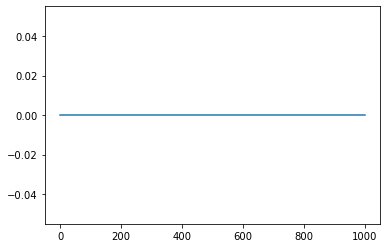

In [7]:
plt.plot(rho0)

In [8]:
first = np.zeros(len(Rho_mem))
for i in range(len(Rho_mem)):
    first[i]=find_first(Rho_mem[i]>1) 

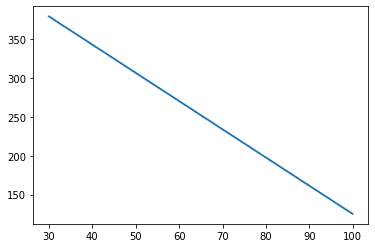

In [9]:
plt.plot(T_mem[500:],first[500:])

In [10]:
front_start = len(T_mem)//2
xfit = np.array(T_mem[front_start:])
yfit = np.array(first[front_start:])
from scipy import stats
s_simu, intercept, r_value, p_value, std_err = stats.linregress(xfit,yfit)

r= -0.9999847666310556
s_simu= -3.642948823887911


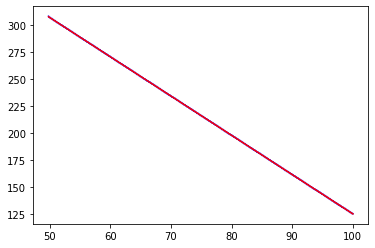

In [11]:

plt.plot(T_mem[front_start:],first[front_start:],c='b')
plt.plot(xfit,intercept+s_simu*xfit, c='r')
print('r=', r_value)
print('s_simu=',s_simu)

In [12]:
def coeffs_P3():
    a = (lbda+f0)
    b = (f0**2+lbda*f0 -f0*F0)
    c = -F0*f0*(lbda+2*f0)
    d = (F0*f0)**2
    return [a,b,c,d]
def coeffs_Q():
    a,b,c,d = coeffs_P3()
    return [a, 2*b, 3*c, 4*d]


In [13]:
# Vitesse theorique Laurent
# def vitesse_theorique(sign=-1):
#     y = np.min( np.roots(coeffs_Q()))
#     p3_y = np.polyval(coeffs_P3(),y)
#     s_sel = sign*np.sqrt(-Temp*(y**4)/p3_y)
#     return s_sel

def vitesse_theorique(epsilon= .001,sign=-1):
    roots_Q = np.roots(coeffs_Q())
    candidats = [sign*1000*np.sqrt(Temp)]
    for x in roots_Q :
        p3_x = np.polyval(coeffs_P3(),x)
        if p3_x < 0:
            candidats += [sign*np.sqrt(-Temp*x**4/p3_x)]
    filtre = []
    for s in candidats:
        s_roots = np.roots([1]+[(s+sign*epsilon)**2*x for x in coeffs_P3()])
        s_roots = s_roots[np.isreal(s_roots)]
        if len(s_roots) == 4:
            filtre += [s]
    if sign == 1:
        s_theorique = np.min(filtre)
    else:
        s_theorique = np.max(filtre)
    return s_theorique

In [14]:
s_sel=vitesse_theorique(sign=1)
print(np.abs(s_simu+s_sel))

1.0135033509723836


In [15]:
for y in np.roots(coeffs_Q()):
    p3_y = np.polyval(coeffs_P3(),y)
    s_t = np.sqrt(-Temp*y**4/p3_y)
    print(s_t)

2.629445472915527
nan
4.310078527970037


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
def plot_roots():
    X =[]
    for n in np.linspace(0,50,10000):
        s = n/2
        roots = np.roots([1]+[s**2*x for x in coeffs_P3()])
        roots = roots[np.isreal(roots)]
        for i in range(len(roots)):
            X+=[[s,roots[i]]]

    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    S = []
    Root = []
    for i in range(len(X)):
        S += [X[i][0]]
        Root += [X[i][1]]
    plt.figsize=(3,3)
    plt.axis((-20,1,0,2*vitesse_theorique(sign=1)))
    plt.scatter(Root,S, marker='.')
    plt.axhline(y=vitesse_theorique(sign=1))

/usr/lib/python3.7/site-packages/numpy/core/numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


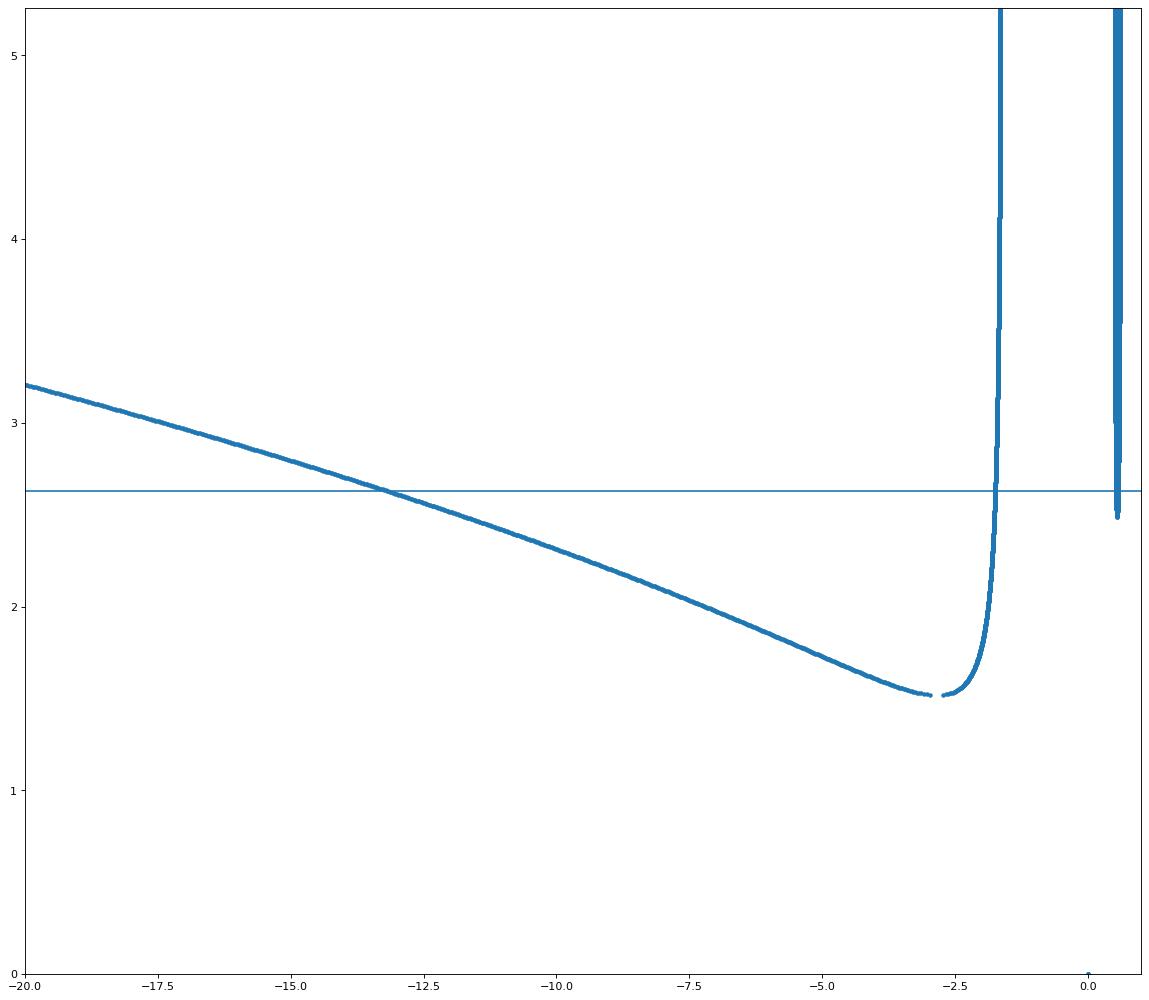

In [17]:
plot_roots()

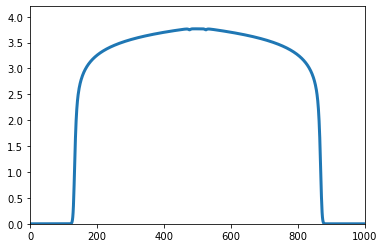

In [18]:
fig = plt.figure()
ax = plt.axes(xlim=(0, Nx), ylim=(0, 4.2))
line, = ax.plot([], [], lw=3)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(X,Rho_mem[20*i][:])
    return line,

ani = animation.FuncAnimation(fig, animate,init_func=init,frames= len(Mu_mem)//20, interval=50, blit=True)

from IPython.display import HTML
HTML(ani.to_jshtml())

In [19]:
s_simu

-3.642948823887911

In [20]:
s_sel

2.629445472915527